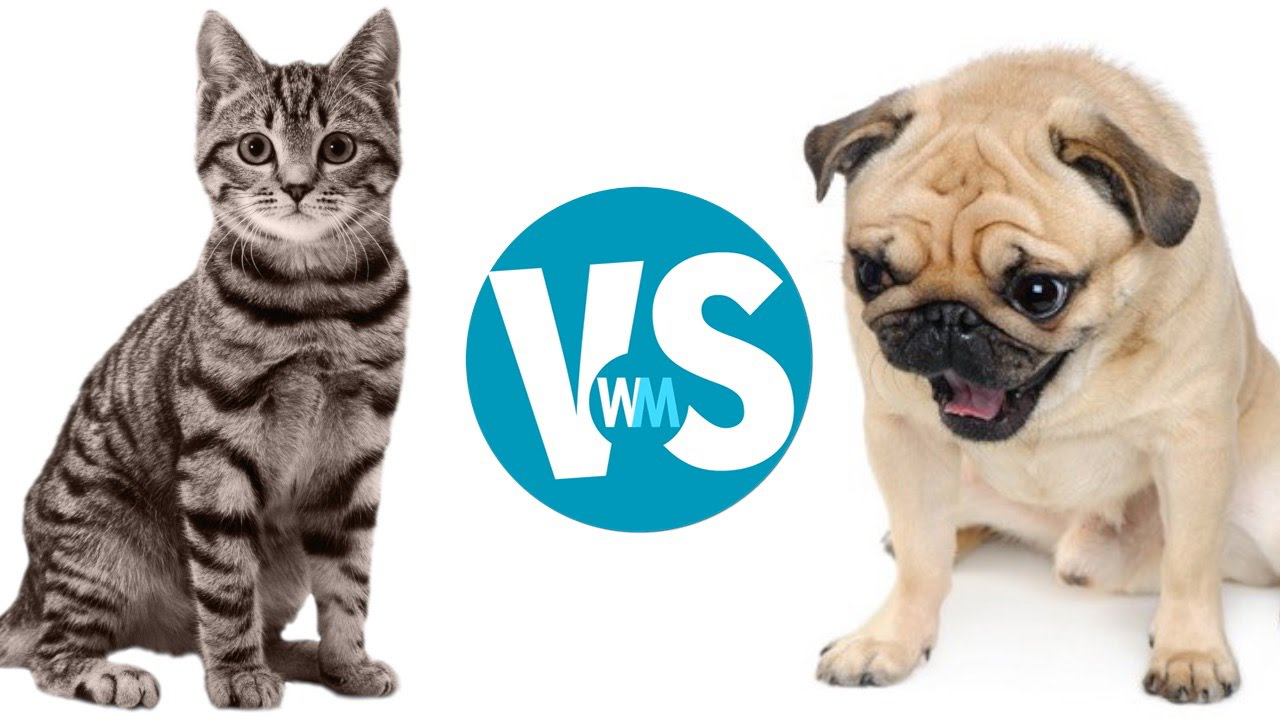

In [35]:
response = requests.get('https://i.ytimg.com/vi/IiilA0dsciY/maxresdefault.jpg')
img = Image.open(BytesIO(response.content))
img

In [1]:
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import  BatchNormalization

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
import zlib
import zipfile

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D


import seaborn as sns
import random
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.image as mpimg

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
 

--2020-07-17 15:06:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  74.0MB/s    in 0.9s    

2020-07-17 15:06:22 (74.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
def plot_train_valid(acc,val_acc,loss,val_loss,epochs):
    sns.set(font_scale=1.4, style="whitegrid")
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs[2:], loss[2:], 'bo', label='Training loss')
    plt.plot(epochs[2:], val_loss[2:], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ = zipfile.ZipFile(local_zip)
zip_.extractall()
zip_.close()

In [5]:
base_dir = "/content/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, 'train') #uczący
validation_dir = os.path.join(base_dir, 'validation') #walidacyjny


train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir))) #liczba zdjęć kotów w zbiorze uczącym
print('total training dog images:', len(os.listdir(train_dogs_dir))) #liczba zdjęć psów w zbiorze uczącym
print('total validation cat images:', len(os.listdir(validation_cats_dir))) #liczba zdjęć kotów w zbiorze walidacyjnym
print('total validation dog images:', len(os.listdir(validation_dogs_dir))) #liczba zdjęć psów w zbiorze walidacyjnym


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


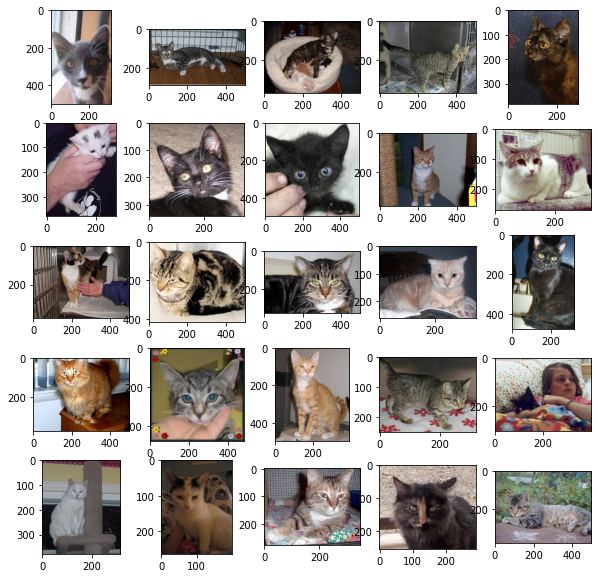

In [7]:
cats = os.listdir(train_cats_dir)
cats_files = [os.path.join(train_cats_dir, file) for file in cats][:25]

plt.figure(figsize= (10,10))

for idx, img_path in enumerate(cats_files):
  plt.subplot(5,5, idx+1)

  img = mpimage.imread(img_path)
  plt.imshow(img)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=128, #liczba zdjęć do trenowania do jednej epoki
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# First model: 2 x Conv2D

# Accuracy = 0.72 but high overfitting


Epoch 1/25
15/15 [==============================] - 9s 619ms/step - loss: 2.0523 - acc: 0.4915 - val_loss: 0.6918 - val_acc: 0.5135
Epoch 2/25
15/15 [==============================] - 9s 608ms/step - loss: 0.6753 - acc: 0.5753 - val_loss: 0.6887 - val_acc: 0.5502
Epoch 3/25
15/15 [==============================] - 9s 609ms/step - loss: 0.6040 - acc: 0.6704 - val_loss: 0.5996 - val_acc: 0.6433
Epoch 4/25
15/15 [==============================] - 9s 616ms/step - loss: 0.5029 - acc: 0.7505 - val_loss: 0.6027 - val_acc: 0.6948
Epoch 5/25
15/15 [==============================] - 8s 557ms/step - loss: 0.3863 - acc: 0.8381 - val_loss: 0.6612 - val_acc: 0.6736
Epoch 6/25
15/15 [==============================] - 9s 591ms/step - loss: 0.2893 - acc: 0.8894 - val_loss: 0.6525 - val_acc: 0.6799
Epoch 7/25
15/15 [==============================] - 9s 598ms/step - loss: 0.1993 - acc: 0.9375 - val_loss: 0.5925 - val_acc: 0.7062
Epoch 8/25
15/15 [==============================] - 9s 600ms/step - loss: 0.

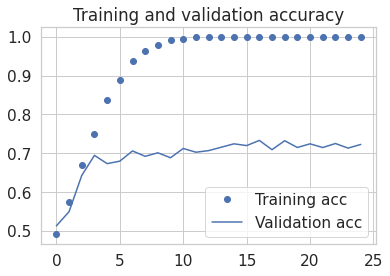

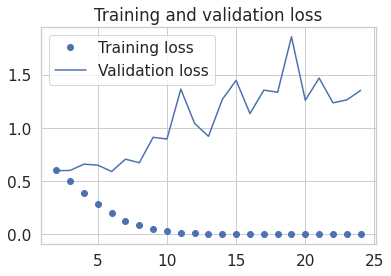

In [26]:
model_one = models.Sequential() #model sekwencyjny

model_one.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_one.add(layers.MaxPooling2D((2, 2)))

model_one.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_one.add(layers.MaxPooling2D((2, 2)))

model_one.add(layers.Flatten())


model_one.add(layers.Dense(512, activation='relu'))   
model_one.add(layers.Dense(1, activation='sigmoid'))  

model_one.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_one.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Second model: 3 x Conv2d

# Accuracy 0.74, also high overfitting

Epoch 1/25
15/15 [==============================] - 10s 643ms/step - loss: 0.9740 - acc: 0.4984 - val_loss: 0.7024 - val_acc: 0.5008
Epoch 2/25
15/15 [==============================] - 9s 627ms/step - loss: 0.6878 - acc: 0.5123 - val_loss: 0.6768 - val_acc: 0.6361
Epoch 3/25
15/15 [==============================] - 9s 623ms/step - loss: 0.6704 - acc: 0.5908 - val_loss: 0.6529 - val_acc: 0.6481
Epoch 4/25
15/15 [==============================] - 9s 612ms/step - loss: 0.6353 - acc: 0.6442 - val_loss: 0.5842 - val_acc: 0.6721
Epoch 5/25
15/15 [==============================] - 8s 561ms/step - loss: 0.5895 - acc: 0.7014 - val_loss: 0.5880 - val_acc: 0.6760
Epoch 6/25
15/15 [==============================] - 9s 591ms/step - loss: 0.5486 - acc: 0.7238 - val_loss: 0.5258 - val_acc: 0.7182
Epoch 7/25
15/15 [==============================] - 9s 589ms/step - loss: 0.4969 - acc: 0.7634 - val_loss: 0.6427 - val_acc: 0.7150
Epoch 8/25
15/15 [==============================] - 9s 608ms/step - loss: 0

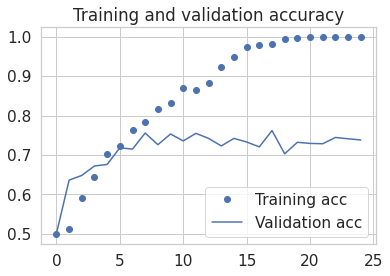

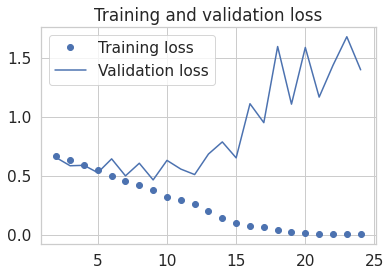

In [28]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  

model_two.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_two.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Third model: 4 x Conv2d 

# Accuracy 0.73, also high overfitting




Epoch 1/25
15/15 [==============================] - 10s 634ms/step - loss: 0.7806 - acc: 0.4792 - val_loss: 0.6940 - val_acc: 0.5016
Epoch 2/25
15/15 [==============================] - 9s 629ms/step - loss: 0.6898 - acc: 0.5292 - val_loss: 0.6869 - val_acc: 0.5406
Epoch 3/25
15/15 [==============================] - 9s 625ms/step - loss: 0.6829 - acc: 0.5724 - val_loss: 0.6524 - val_acc: 0.5772
Epoch 4/25
15/15 [==============================] - 9s 618ms/step - loss: 0.6429 - acc: 0.6277 - val_loss: 0.5997 - val_acc: 0.6761
Epoch 5/25
15/15 [==============================] - 8s 556ms/step - loss: 0.6254 - acc: 0.6581 - val_loss: 0.6317 - val_acc: 0.6361
Epoch 6/25
15/15 [==============================] - 9s 589ms/step - loss: 0.6076 - acc: 0.6806 - val_loss: 0.5945 - val_acc: 0.6847
Epoch 7/25
15/15 [==============================] - 9s 612ms/step - loss: 0.5624 - acc: 0.7010 - val_loss: 0.6094 - val_acc: 0.6385
Epoch 8/25
15/15 [==============================] - 9s 603ms/step - loss: 0

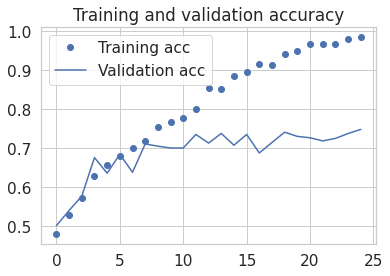

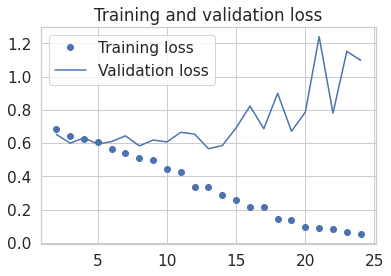

In [29]:
model_third = models.Sequential() #model sekwencyjny

model_third.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_third.add(layers.MaxPooling2D((2, 2)))

model_third.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_third.add(layers.MaxPooling2D((2, 2)))

model_third.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_third.add(layers.MaxPooling2D((2, 2)))

model_third.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_third.add(layers.MaxPooling2D((2, 2)))

model_third.add(layers.Flatten())


model_third.add(layers.Dense(512, activation='relu'))   
model_third.add(layers.Dense(1, activation='sigmoid'))  

model_third.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_third.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Second model is the best, lets try to tackle with overfitting using dropout

# Second model: 3 x Conv2d + 2 Dropout(0.5)

# Accuracy 0.69 -  worst results, also high overfitting

Epoch 1/25
15/15 [==============================] - 10s 636ms/step - loss: 2.0348 - acc: 0.5160 - val_loss: 0.6933 - val_acc: 0.4936
Epoch 2/25
15/15 [==============================] - 9s 611ms/step - loss: 0.6937 - acc: 0.4936 - val_loss: 0.6931 - val_acc: 0.5191
Epoch 3/25
15/15 [==============================] - 9s 616ms/step - loss: 0.6931 - acc: 0.5089 - val_loss: 0.6935 - val_acc: 0.4881
Epoch 4/25
15/15 [==============================] - 10s 640ms/step - loss: 0.6931 - acc: 0.4989 - val_loss: 0.6929 - val_acc: 0.4992
Epoch 5/25
15/15 [==============================] - 8s 566ms/step - loss: 0.6931 - acc: 0.4936 - val_loss: 0.6934 - val_acc: 0.4976
Epoch 6/25
15/15 [==============================] - 9s 596ms/step - loss: 0.6927 - acc: 0.5235 - val_loss: 0.6932 - val_acc: 0.5374
Epoch 7/25
15/15 [==============================] - 9s 607ms/step - loss: 0.6912 - acc: 0.5380 - val_loss: 0.6884 - val_acc: 0.5565
Epoch 8/25
15/15 [==============================] - 9s 620ms/step - loss: 

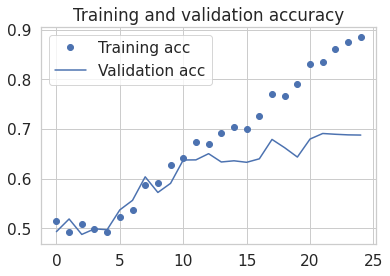

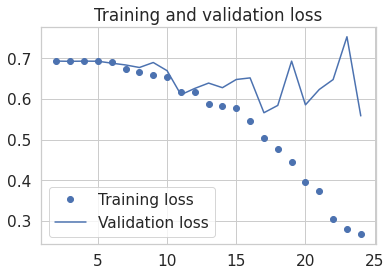

In [33]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.5))

model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.5))

model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  

model_two.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_two.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Second model: 3 x Conv2d + 2 Dropout(0.2)
# Accuracy 0.70 - worst results, also high overfitting

Epoch 1/25
15/15 [==============================] - 10s 634ms/step - loss: 1.4556 - acc: 0.4989 - val_loss: 0.6929 - val_acc: 0.5239
Epoch 2/25
15/15 [==============================] - 9s 627ms/step - loss: 0.6927 - acc: 0.5219 - val_loss: 0.6927 - val_acc: 0.5494
Epoch 3/25
15/15 [==============================] - 9s 629ms/step - loss: 0.6900 - acc: 0.5310 - val_loss: 0.6885 - val_acc: 0.5884
Epoch 4/25
15/15 [==============================] - 10s 638ms/step - loss: 0.6859 - acc: 0.5465 - val_loss: 0.6877 - val_acc: 0.6015
Epoch 5/25
15/15 [==============================] - 9s 570ms/step - loss: 0.6708 - acc: 0.5865 - val_loss: 0.6850 - val_acc: 0.5701
Epoch 6/25
15/15 [==============================] - 9s 597ms/step - loss: 0.6466 - acc: 0.6223 - val_loss: 0.6147 - val_acc: 0.6521
Epoch 7/25
15/15 [==============================] - 9s 611ms/step - loss: 0.5952 - acc: 0.6763 - val_loss: 0.6066 - val_acc: 0.6306
Epoch 8/25
15/15 [==============================] - 9s 620ms/step - loss: 

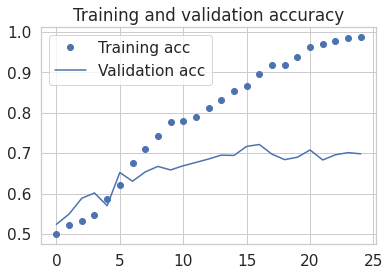

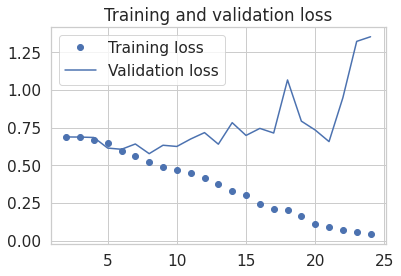

In [34]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.2))

model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.2))

model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  

model_two.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_two.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Second model: 3 x Conv2d x 2 Padding  + 2 Dropout(0.2)
# Accuracy 0.68 - worst results, also high overfitting

Epoch 1/25
15/15 [==============================] - 16s 1s/step - loss: 0.8100 - acc: 0.5128 - val_loss: 0.6932 - val_acc: 0.4952
Epoch 2/25
15/15 [==============================] - 11s 744ms/step - loss: 0.6933 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5287
Epoch 3/25
15/15 [==============================] - 11s 738ms/step - loss: 0.6921 - acc: 0.5230 - val_loss: 0.6889 - val_acc: 0.5533
Epoch 4/25
15/15 [==============================] - 11s 745ms/step - loss: 0.6834 - acc: 0.5785 - val_loss: 0.6847 - val_acc: 0.5649
Epoch 5/25
15/15 [==============================] - 11s 707ms/step - loss: 0.6813 - acc: 0.5737 - val_loss: 0.6828 - val_acc: 0.5295
Epoch 6/25
15/15 [==============================] - 11s 721ms/step - loss: 0.6943 - acc: 0.5299 - val_loss: 0.6852 - val_acc: 0.5430
Epoch 7/25
15/15 [==============================] - 11s 740ms/step - loss: 0.6685 - acc: 0.5935 - val_loss: 0.6489 - val_acc: 0.6346
Epoch 8/25
15/15 [==============================] - 12s 806ms/step - los

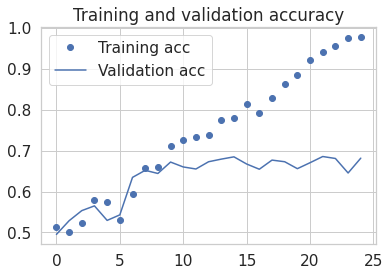

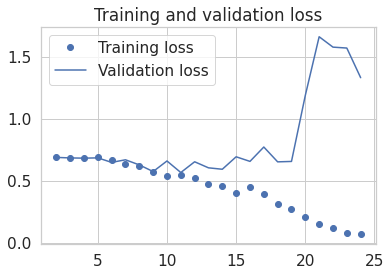

In [36]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.2))

model_two.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(layers.Dropout(0.2))

model_two.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  

model_two.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_two.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Second model: 3 x 2 BatchNormalization
# Accuracy 0.60 - worst results, also high overfitting

Epoch 1/25
15/15 [==============================] - 10s 675ms/step - loss: 9.8180 - acc: 0.5027 - val_loss: 0.6893 - val_acc: 0.5032
Epoch 2/25
15/15 [==============================] - 9s 623ms/step - loss: 0.6853 - acc: 0.5684 - val_loss: 0.6883 - val_acc: 0.4960
Epoch 3/25
15/15 [==============================] - 10s 634ms/step - loss: 0.6645 - acc: 0.6095 - val_loss: 0.6909 - val_acc: 0.5358
Epoch 4/25
15/15 [==============================] - 10s 645ms/step - loss: 0.6502 - acc: 0.6373 - val_loss: 0.6994 - val_acc: 0.5317
Epoch 5/25
15/15 [==============================] - 9s 606ms/step - loss: 0.6310 - acc: 0.6521 - val_loss: 0.7008 - val_acc: 0.5533
Epoch 6/25
15/15 [==============================] - 9s 593ms/step - loss: 0.6173 - acc: 0.6891 - val_loss: 0.6875 - val_acc: 0.5932
Epoch 7/25
15/15 [==============================] - 9s 623ms/step - loss: 0.5991 - acc: 0.6958 - val_loss: 0.6849 - val_acc: 0.5645
Epoch 8/25
15/15 [==============================] - 10s 647ms/step - loss

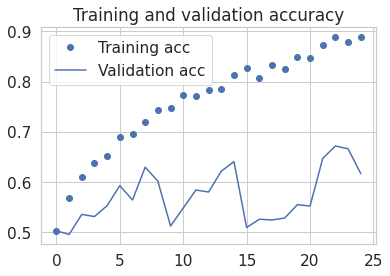

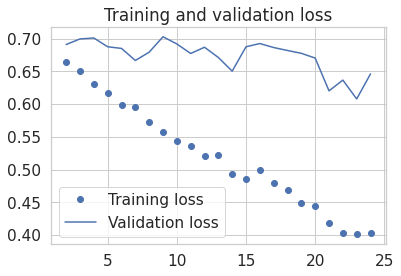

In [39]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(BatchNormalization())

model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))
model_two.add(BatchNormalization())

model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  

model_two.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])

history = model_two.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Lets try increase training data by rotation data 

In [16]:
datagen_rotate = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

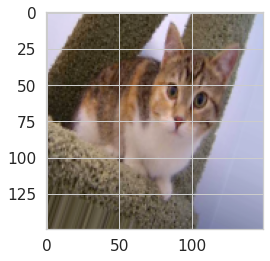

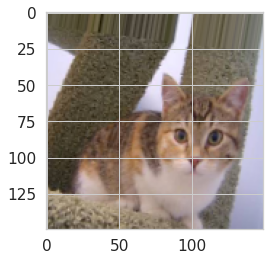

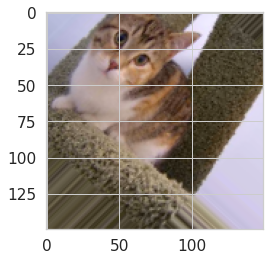

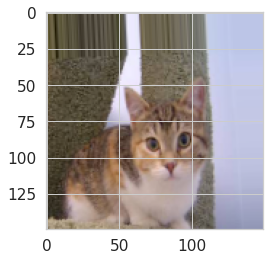

In [17]:
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[random.randint(1,1000)]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen_rotate.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# Second model: 3 x Conv2D + rotation data
# Accuracy 0.70 - worst results, also high overfitting

In [ ]:
model_two = models.Sequential() #model sekwencyjny

model_two.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_two.add(layers.MaxPooling2D((2, 2)))


model_two.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))


model_two.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_two.add(layers.MaxPooling2D((2, 2)))

model_two.add(layers.Flatten())


model_two.add(layers.Dense(512, activation='relu'))   
model_two.add(layers.Dense(1, activation='sigmoid'))  


model_two.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
                  metrics=['acc'])


In [19]:

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_rotate = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator_rotate = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model_two.fit_generator(
        train_generator_rotate,
        steps_per_epoch=15,
        epochs=25,
        validation_data=validation_generator_rotate,
        validation_steps=5)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/25
15/15 [==============================] - 3s 186ms/step - loss: 0.8862 - acc: 0.5375 - val_loss: 0.6833 - val_acc: 0.5063
Epoch 2/25
15/15 [==============================] - 2s 125ms/step - loss: 0.6910 - acc: 0.5323 - val_loss: 0.6792 - val_acc: 0.5250
Epoch 3/25
15/15 [==============================] - 2s 136ms/step - loss: 0.6878 - acc: 0.5437 - val_loss: 0.7138 - val_acc: 0.5625
Epoch 4/25
15/15 [==============================] - 2s 137ms/step - loss: 0.6814 - acc: 0.5479 - val_loss: 0.7389 - val_acc: 0.5562
Epoch 5/25
15/15 [==============================] - 2s 133ms/step - loss: 0.6904 - acc: 0.5948 - val_loss: 0.6978 - val_acc: 0.6375
Epoch 6/25
15/15 [==============================] - 2s 115ms/step - loss: 0.6717 - acc: 0.5688 - val_loss: 0.6965 - val_acc: 0.5437
Epoch 7/25
15/15 [==============================] - 2s 144ms/step - loss: 0.6646 - acc: 0.5979 - val_loss: 0.6419 - val_acc:

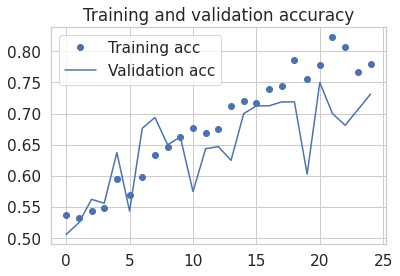

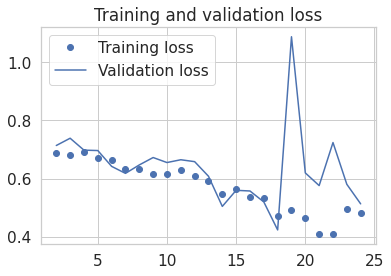

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Tansfer Lerning

# Lets use trained model = VGG19

# ###############################################

# Much better Accuracy 0.94

# Model :VGG19
    
# Optymizer: optimizers.SGD(lr=0.0001, momentum=0.9)

Epoch 1/25
15/15 [==============================] - 51s 3s/step - loss: 0.7068 - acc: 0.5031 - val_loss: 0.6660 - val_acc: 0.5971
Epoch 2/25
15/15 [==============================] - 42s 3s/step - loss: 0.6538 - acc: 0.6432 - val_loss: 0.6205 - val_acc: 0.6736
Epoch 3/25
15/15 [==============================] - 32s 2s/step - loss: 0.6022 - acc: 0.7111 - val_loss: 0.5864 - val_acc: 0.7675
Epoch 4/25
15/15 [==============================] - 33s 2s/step - loss: 0.5572 - acc: 0.7788 - val_loss: 0.5389 - val_acc: 0.7670
Epoch 5/25
15/15 [==============================] - 33s 2s/step - loss: 0.5042 - acc: 0.8125 - val_loss: 0.5079 - val_acc: 0.8304
Epoch 6/25
15/15 [==============================] - 33s 2s/step - loss: 0.4398 - acc: 0.8451 - val_loss: 0.4370 - val_acc: 0.8416
Epoch 7/25
15/15 [==============================] - 33s 2s/step - loss: 0.3915 - acc: 0.8531 - val_loss: 0.4109 - val_acc: 0.8591
Epoch 8/25
15/15 [==============================] - 34s 2s/step - loss: 0.3320 - acc: 0.88

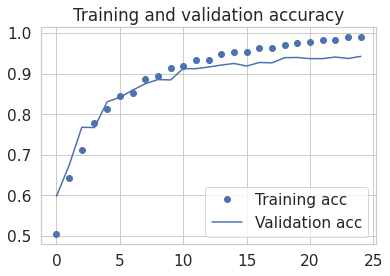

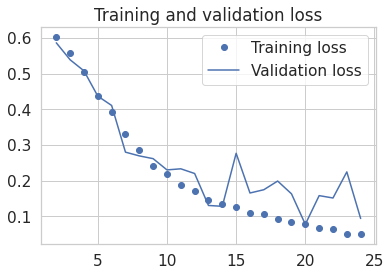

In [28]:
base_model = VGG19(include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[1:]: #input layer ma być na False
    layer.trainable = True


model = Sequential([
    base_model,
    
    Flatten(), #<= bridge between conv layers and full connected layers
    
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    
])

model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
                  metrics=['acc'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Model :VGG19 + rotation data
# Accuracy 0.95

Epoch 1/25
15/15 [==============================] - 14s 938ms/step - loss: 0.0374 - acc: 0.9958 - val_loss: 0.1422 - val_acc: 0.9406
Epoch 2/25
15/15 [==============================] - 12s 793ms/step - loss: 0.0542 - acc: 0.9849 - val_loss: 0.0153 - val_acc: 0.9406
Epoch 3/25
15/15 [==============================] - 10s 634ms/step - loss: 0.0651 - acc: 0.9833 - val_loss: 0.0781 - val_acc: 0.9500
Epoch 4/25
15/15 [==============================] - 10s 677ms/step - loss: 0.0896 - acc: 0.9667 - val_loss: 0.0985 - val_acc: 0.9392
Epoch 5/25
15/15 [==============================] - 10s 636ms/step - loss: 0.0511 - acc: 0.9854 - val_loss: 0.1649 - val_acc: 0.9031
Epoch 6/25
15/15 [==============================] - 10s 637ms/step - loss: 0.0463 - acc: 0.9875 - val_loss: 0.2028 - val_acc: 0.9375
Epoch 7/25
15/15 [==============================] - 10s 636ms/step - loss: 0.0353 - acc: 0.9958 - val_loss: 0.2765 - val_acc: 0.9223
Epoch 8/25
15/15 [==============================] - 10s 637ms/step - 

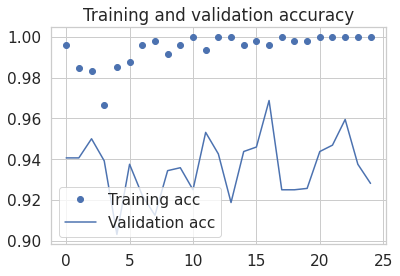

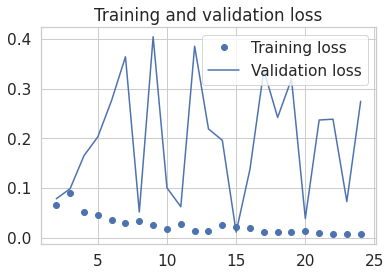

In [34]:
base_model = VGG19(include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[1:]: #input layer ma być na False
    layer.trainable = True


model_rotation = Sequential([
    base_model,
    
    Flatten(), #<= bridge between conv layers and full connected layers
    
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    
])

model_rotation.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
                  metrics=['acc'])


history = model.fit_generator(
    train_generator_rotate,
    steps_per_epoch=15,
    epochs=25, #zmieniona liczba epok
 
    validation_data=validation_generator_rotate,
    validation_steps=10)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plot_train_valid(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss,epochs=epochs)

# Mode VGG16 in practice cases

In [26]:
def recognize(u):
  url_img = u
  ##pobiera 
  response = requests.get(url_img)
  img = Image.open(BytesIO(response.content))
  # ### zmieniam rozmiar
  img = img.resize((150,150))
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  categories = ["Cat","Dog"]
  y_pred = model.predict(X)
  y_pred 
  return print("Wynik:"),  print(categories[int(y_pred[0][0])])



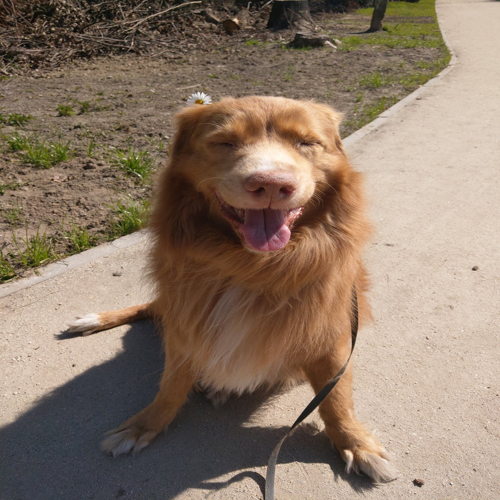

In [31]:
u = r'https://scontent-frt3-1.xx.fbcdn.net/v/t1.15752-9/109718968_373686596940681_7905956211827781085_n.jpg?_nc_cat=107&_nc_sid=b96e70&_nc_ohc=t4STSl8SEGcAX_YgwqL&_nc_ht=scontent-frt3-1.xx&oh=7629c417b97ebe180ebed758dd500954&oe=5F365F7E'
response = requests.get(u)
img = Image.open(BytesIO(response.content))
img.resize((500,500))


In [32]:
recognize(u)

Wynik:
Dog


(None, None)

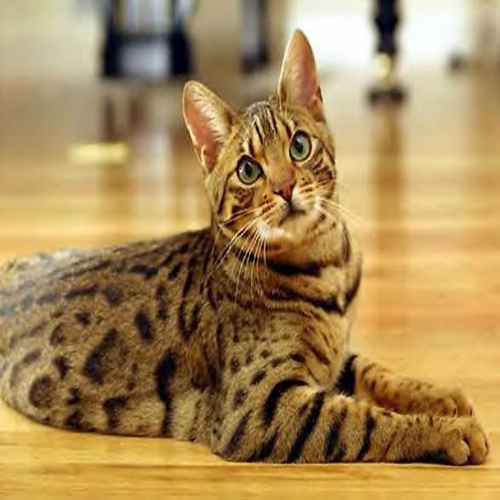

In [24]:
u = r'https://dinoanimals.pl/wp-content/uploads/2014/12/Kot_bengalski_2.jpg'
response = requests.get(u)
img = Image.open(BytesIO(response.content))
img.resize((500,500))


In [29]:
recognize(u)

Wynik:
Cat


(None, None)